In [1]:
#sc.stop()

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkContext

spark = SparkSession\
    .builder\
    .master("local[4]")\
    .appName("MLib Clustering")\
    .getOrCreate()

sc = spark.sparkContext

In [3]:
sc._conf.getAll()

[('spark.driver.port', '34279'),
 ('spark.local.dir', '/home/marco/claseBigData/ProyectoBD/tmp'),
 ('spark.executor.id', 'driver'),
 ('spark.driver.memory', '16g'),
 ('spark.app.name', 'PySparkShell'),
 ('spark.driver.host', '192.168.3.5'),
 ('spark.app.startTime', '1638859438705'),
 ('spark.sql.catalogImplementation', 'hive'),
 ('spark.rdd.compress', 'True'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.submit.pyFiles', ''),
 ('spark.submit.deployMode', 'client'),
 ('spark.app.id', 'local-1638859439303'),
 ('spark.ui.showConsoleProgress', 'true')]

### Carga de Datos

In [4]:
autoData = sc.textFile("clase/auto-data.csv")
autoData.cache()
autoData.take(5)

['MAKE,FUELTYPE,ASPIRE,DOORS,BODY,DRIVE,CYLINDERS,HP,RPM,MPG-CITY,MPG-HWY,PRICE',
 'subaru,gas,std,two,hatchback,fwd,four,69,4900,31,36,5118',
 'chevrolet,gas,std,two,hatchback,fwd,three,48,5100,47,53,5151',
 'mazda,gas,std,two,hatchback,fwd,four,68,5000,30,31,5195',
 'toyota,gas,std,two,hatchback,fwd,four,62,4800,35,39,5348']

In [5]:
# Eliminar cabeceras
firstLine = autoData.first()
dataLines = autoData.filter(lambda l: l!=firstLine)
dataLines.count()

197

### Preprocesamiento de datos

In [6]:
from pyspark.sql import Row

import math
from pyspark.ml.linalg import Vectors

# Convertir a un vector
def transformToNumeric(inputStr):
    attList = inputStr.split(",")
    
    doors = 1.0 if attList[3] == "two" else 2.0
    body = 1.0 if attList[4] == "sedan" else 2.0
    
    # Filtrar las columnas innecesarias
    values = Row(DOORS = doors,\
                BODY = float(body),\
                HP = float(attList[7]),\
                RPM = float(attList[8]),\
                MPG = float(attList[9]))
    
    return values

autoMap = dataLines.map(transformToNumeric)
autoMap.persist()
autoMap.collect()

# Infiere el esquema y registra el dataframe como tabla
autoDf = spark.createDataFrame(autoMap)
autoDf.show()

+-----+----+----+------+----+
|DOORS|BODY|  HP|   RPM| MPG|
+-----+----+----+------+----+
|  1.0| 2.0|69.0|4900.0|31.0|
|  1.0| 2.0|48.0|5100.0|47.0|
|  1.0| 2.0|68.0|5000.0|30.0|
|  1.0| 2.0|62.0|4800.0|35.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|60.0|5500.0|38.0|
|  1.0| 1.0|69.0|5200.0|31.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5500.0|37.0|
|  1.0| 2.0|68.0|5000.0|31.0|
|  1.0| 2.0|68.0|5500.0|31.0|
|  2.0| 2.0|68.0|5500.0|31.0|
|  2.0| 2.0|68.0|5500.0|31.0|
|  1.0| 2.0|70.0|5400.0|38.0|
|  1.0| 2.0|62.0|4800.0|31.0|
|  1.0| 2.0|68.0|5500.0|31.0|
|  1.0| 2.0|58.0|4800.0|49.0|
|  2.0| 2.0|62.0|4800.0|31.0|
|  1.0| 2.0|76.0|6000.0|30.0|
|  2.0| 1.0|70.0|5400.0|38.0|
+-----+----+----+------+----+
only showing top 20 rows



In [7]:
# Centrado y escalado

summStats = autoDf.describe().toPandas()
meanValues = summStats.iloc[1,1:5].values.tolist()
stdValues = summStats.iloc[2,1:5].values.tolist()

# Colocamos estos valores en una variable de difusion
bcMeans = sc.broadcast(meanValues)
bcStdDev = sc.broadcast(stdValues)

In [8]:
autoDf.describe().show()

+-------+-------------------+------------------+------------------+------------------+-----------------+
|summary|              DOORS|              BODY|                HP|               RPM|              MPG|
+-------+-------------------+------------------+------------------+------------------+-----------------+
|  count|                197|               197|               197|               197|              197|
|   mean| 1.5685279187817258| 1.532994923857868|103.60406091370558|5118.0203045685275|25.15228426395939|
| stddev|0.49654352778167493|0.5001812579359883|37.639205349518356|481.03591405011446|6.437862917085915|
|    min|                1.0|               1.0|              48.0|            4150.0|             13.0|
|    max|                2.0|               2.0|             262.0|            6600.0|             49.0|
+-------+-------------------+------------------+------------------+------------------+-----------------+



In [9]:
def centerAndScale(inRow):
    global bcMeans
    global bcStdDev
    
    meanArray = bcMeans.value
    stdArray = bcStdDev.value
    
    retArray = []
    for i in range(len(meanArray)):
        retArray.append((float(inRow[i])-float(meanArray[i]))/float(stdArray[i]))
        
    return Vectors.dense(retArray)

In [10]:
csAuto = autoDf.rdd.map(centerAndScale)
csAuto.collect()

[DenseVector([-1.145, 0.9337, -0.9194, -0.4532]),
 DenseVector([-1.145, 0.9337, -1.4773, -0.0375]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -1.1585, 0.7941]),
 DenseVector([-1.145, -1.0656, -0.9194, 0.1704]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -0.9459, -0.2453]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([0.869, 0.9337, -0.9459, 0.7941]),
 DenseVector([0.869, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -0.8928, 0.5862]),
 DenseVector([-1.145, 0.9337, -1.1053, -0.6611]),
 DenseVector([-1.145, 0.9337, -0.9459, 0.7941]),
 DenseVector([-1.145, 0.9337, -1.2116, -0.6611]),
 DenseVector([0.869, 0.9337, -1.1053, -0.6611]),
 DenseVector([-1.145, 0.9337, -0.7334, 1.8335]),
 DenseVector([0.869, -1.0656, -0.8928, 0.5862]),
 DenseVector([

In [11]:
# Crear un marco de datos de Spark
autoRows = csAuto.map(lambda f:Row(features=f))
autoDf = spark.createDataFrame(autoRows)

autoDf.select("features").show(10, truncate = False)

+---------------------------------------------------------------------------------+
|features                                                                         |
+---------------------------------------------------------------------------------+
|[-1.1449709581789205,0.9336716814805123,-0.9193621542317812,-0.4532308258085988] |
|[-1.1449709581789205,0.9336716814805123,-1.477291042607442,-0.03746145358837007] |
|[-1.1449709581789205,0.9336716814805123,-0.9459301965353841,-0.24534613969848443]|
|[-1.1449709581789205,0.9336716814805123,-1.1053384503570014,-0.6611155119187132] |
|[-1.1449709581789205,0.9336716814805123,-0.9459301965353841,0.7940772908520874]  |
|[-1.1449709581789205,0.9336716814805123,-1.1584745349642074,0.7940772908520874]  |
|[-1.1449709581789205,-1.0656035495158018,-0.9193621542317812,0.1704232325217443] |
|[-1.1449709581789205,0.9336716814805123,-0.9459301965353841,0.7940772908520874]  |
|[-1.1449709581789205,0.9336716814805123,-0.9459301965353841,0.7940772908520

### Aplicar el Algoritmo de Cluster

In [12]:
from pyspark.ml.clustering import KMeans
Kmeans = KMeans(k=3,seed=1)
model = Kmeans.fit(autoDf)
predictions = model.transform(autoDf)
predictions.show(10,truncate = False)

+---------------------------------------------------------------------------------+----------+
|features                                                                         |prediction|
+---------------------------------------------------------------------------------+----------+
|[-1.1449709581789205,0.9336716814805123,-0.9193621542317812,-0.4532308258085988] |0         |
|[-1.1449709581789205,0.9336716814805123,-1.477291042607442,-0.03746145358837007] |0         |
|[-1.1449709581789205,0.9336716814805123,-0.9459301965353841,-0.24534613969848443]|0         |
|[-1.1449709581789205,0.9336716814805123,-1.1053384503570014,-0.6611155119187132] |0         |
|[-1.1449709581789205,0.9336716814805123,-0.9459301965353841,0.7940772908520874]  |0         |
|[-1.1449709581789205,0.9336716814805123,-1.1584745349642074,0.7940772908520874]  |0         |
|[-1.1449709581789205,-1.0656035495158018,-0.9193621542317812,0.1704232325217443] |0         |
|[-1.1449709581789205,0.9336716814805123,-0.945930

In [13]:
# Plot de los resultados en un scatter plot
import pandas as pd

def unstripData(instr):
    return (instr["prediction"],instr["features"][0],\
           instr["features"][1],instr["features"][2],instr["features"][3])

unstripped = predictions.rdd.map(unstripData)
predList = unstripped.collect()
predPd = pd.DataFrame(predList)
print(predPd)

     0         1         2         3         4
0    0 -1.144971  0.933672 -0.919362 -0.453231
1    0 -1.144971  0.933672 -1.477291 -0.037461
2    0 -1.144971  0.933672 -0.945930 -0.245346
3    0 -1.144971  0.933672 -1.105338 -0.661116
4    0 -1.144971  0.933672 -0.945930  0.794077
..  ..       ...       ...       ...       ...
192  1  0.868951 -1.065604  2.082827  0.586193
193  2 -1.144971  0.933672  2.747028  1.625616
194  1  0.868951 -1.065604  2.135963 -1.284770
195  2 -1.144971 -1.065604  2.082827  0.586193
196  2 -1.144971  0.933672  2.135963 -1.284770

[197 rows x 5 columns]


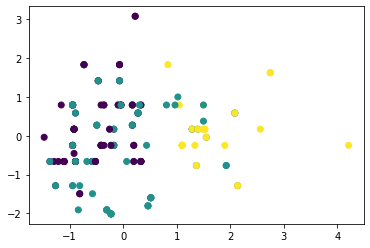

In [14]:
import matplotlib.pyplot as plt
plt.cla()
plt.scatter(predPd[3],predPd[4],c=predPd[0])

In [15]:
sc.stop()

In [16]:
import sys
print(sys.executable)
print(sys.version)
print(sys.version_info)

/home/marco/anaconda3/bin/python
3.8.3 (default, Jul  2 2020, 16:21:59) 
[GCC 7.3.0]
sys.version_info(major=3, minor=8, micro=3, releaselevel='final', serial=0)
